# Experiment 1: k-Shape on Raw Time Series

## Select context csv to work with (see above)

In [6]:
import pandas as pd
df_weekday = pd.read_csv('data/weekdayContext.csv')
# in this notebook we use Week Day Context

## Download TSFRESH library 

First from: https://github.com/blue-yonder/tsfresh

In [4]:
from kshape.core import kshape, zscore


Also from: https://tslearn.readthedocs.io/en/latest/auto_examples/plot_kshape.html#

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.plotly as py

from scipy.spatial.distance import cdist
from collections import Counter

from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import KShape

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import pairwise_distances

from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer


In [76]:
"""
Function to calculate average and sample silhouette score of dataset X for each cluster in rangeK.
Additionally, a plot of each cluster with their instances sorted by their silhouette score, 
in descending order, with a dashed red line of overall average.
"""
def plotSilhouettes(X, rangeK, seed):
    for k in rangeK:
        fig = plt.figure(figsize=(18,8))
        ax = fig.add_subplot(1, 1, 1)

        # The (k+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax.set_ylim([0, len(X) + (k + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed for reproducibility.
        sz = X.shape[1]
        ks_clusterer = KShape(n_clusters=k, verbose=True, random_state=seed)
        cluster_labels = ks_clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For k = {}. The average silhouette_score is : {}.".format(k, silhouette_avg))

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(k):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / k)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize = 20)

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax.set_xlabel("Silhouette Coefficient Values", fontsize = 20)
        ax.set_ylabel("Cluster Label", fontsize = 20)

        # The vertical line for average silhouette score of all the values
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax.set_yticks([]) # Clear the yaxis labels/ticks

        plt.suptitle(("Silhouette Analysis for KMeans clustering "
                      "with num. clusters = %d" % k),
                     fontsize=19, fontweight='bold')
    # plot all genereated figures
    plt.show()


## Run k-Shape algorithm


Observations from the github repo:
- If the data is available from different sources with same frequency but at different points in time, it needs to be aligned.
- kshape also expect no time series with a constant observation value or 'N/A'

Distance measure: normalized cross-correlation measure (consider the shape while comparing them)

Shape of X matrix: (368, 238)
0.146 --> 0.125 --> 0.119 --> 0.113 --> 0.108 --> 0.102 --> 0.108 --> 


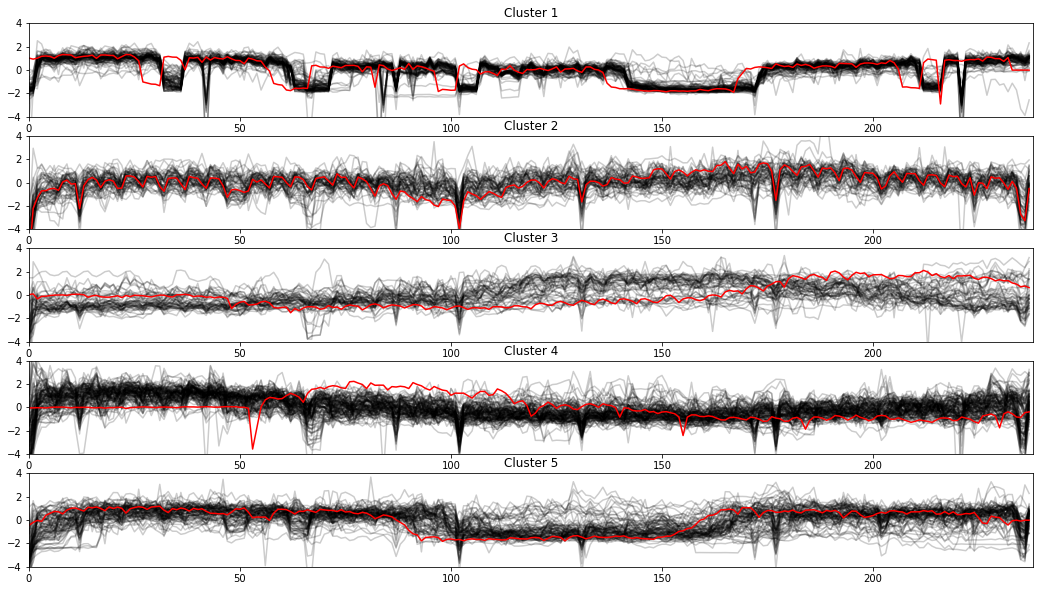

In [66]:
# get rid of building ID
bdg_id = df_weekday.iloc[:, 0]
df_weekday_noID = df_weekday.copy()
del df_weekday_noID['Unnamed: 0']

weekday_X_train = TimeSeriesScalerMeanVariance().fit_transform(np.squeeze(df_weekday_noID.values))
# dataFrame.values will generate a 3d arra (the third dimension being 1) so we convert it to a 2d array
weekday_X_train = np.squeeze(weekday_X_train) # now is a 2d array
print("Shape of X matrix: {}".format(weekday_X_train.shape))

sz = weekday_X_train.shape[1]

seed = 3
k = 5
ks = KShape(n_clusters=k, verbose=True, random_state=seed)
y_pred = ks.fit_predict(weekday_X_train)

plt.figure(figsize=(18,10))
for yi in range(k):
    plt.subplot(k, 1, 1 + yi)
    for xx in weekday_X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))

# plt.tight_layout()
plt.show()

## Evaluation:

### Evaluate resulting clusters with sillouhette coefficient plot

0.187 --> 0.168 --> 0.165 --> 0.166 --> 
For k = 2. The average silhouette_score is : 0.11100528588323248.
0.175 --> 0.146 --> 0.140 --> 0.135 --> 0.132 --> 0.131 --> 0.139 --> 
For k = 3. The average silhouette_score is : 0.14554646727504886.
0.180 --> 0.153 --> 0.141 --> 0.138 --> 0.134 --> 0.131 --> 0.129 --> 0.127 --> 0.126 --> 0.125 --> 0.124 --> 0.123 --> 0.122 --> 0.121 --> 0.121 --> 0.121 --> 0.121 --> 0.120 --> 0.120 --> 0.120 --> 0.120 --> 
For k = 4. The average silhouette_score is : 0.10671116776238278.
0.146 --> 0.125 --> 0.119 --> 0.113 --> 0.108 --> 0.102 --> 0.108 --> 
For k = 5. The average silhouette_score is : 0.14122774903265298.
0.155 --> 0.124 --> 0.111 --> 0.102 --> 0.093 --> 0.090 --> 0.096 --> 
For k = 6. The average silhouette_score is : 0.13198803823336736.


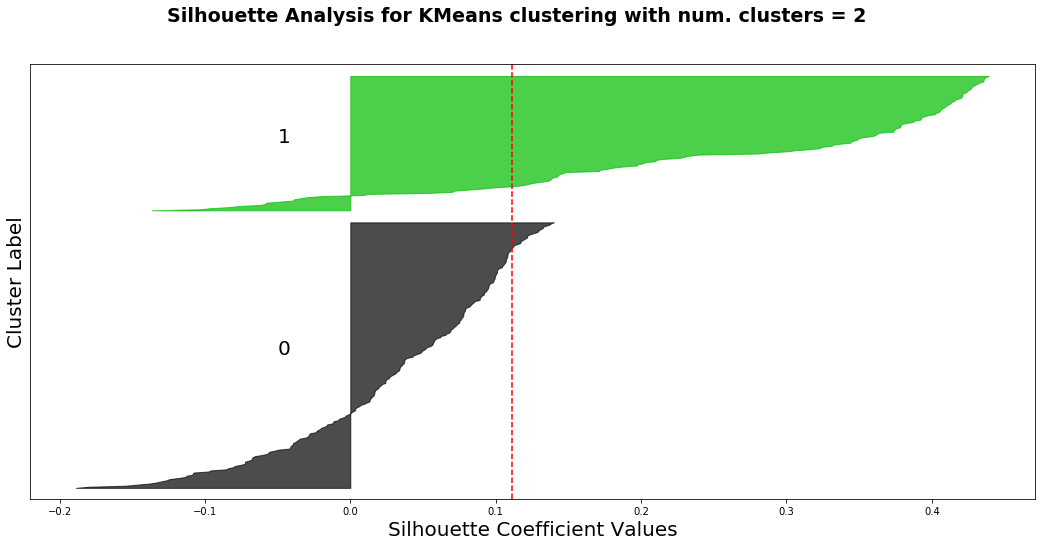

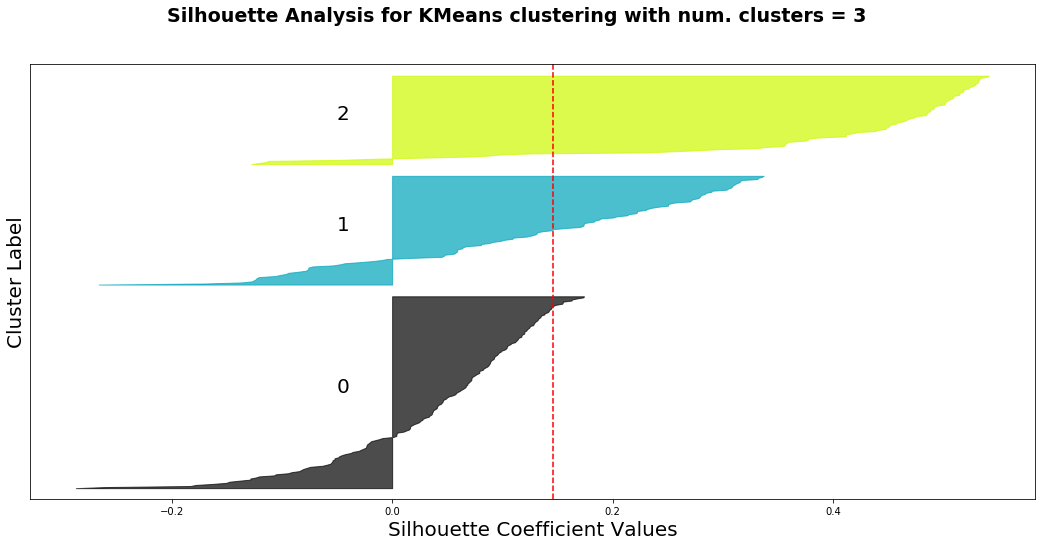

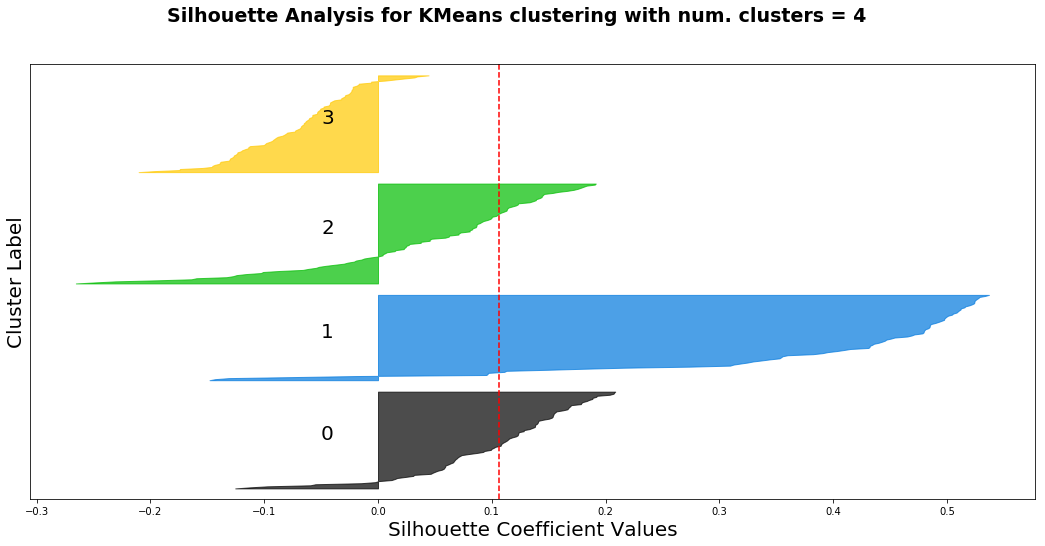

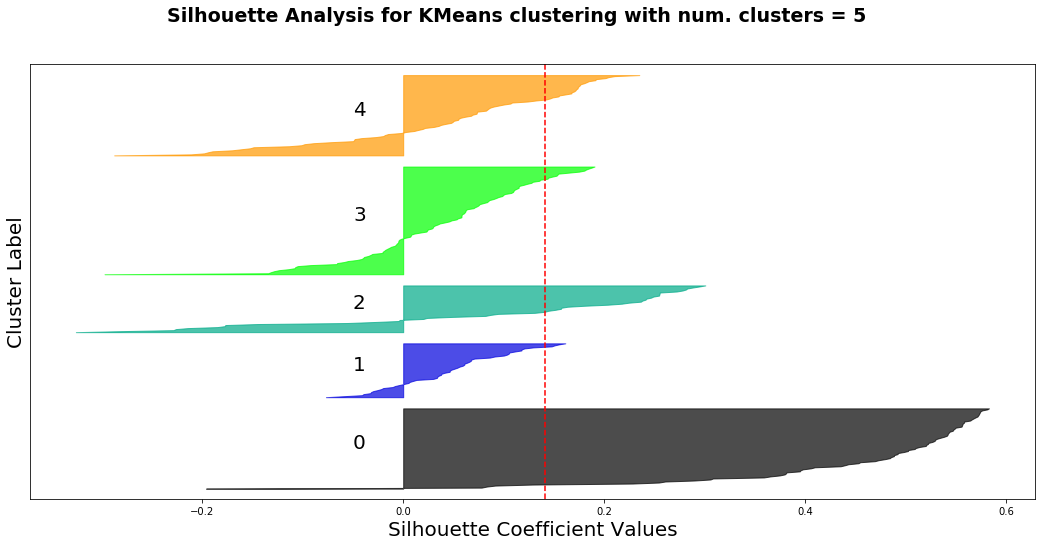

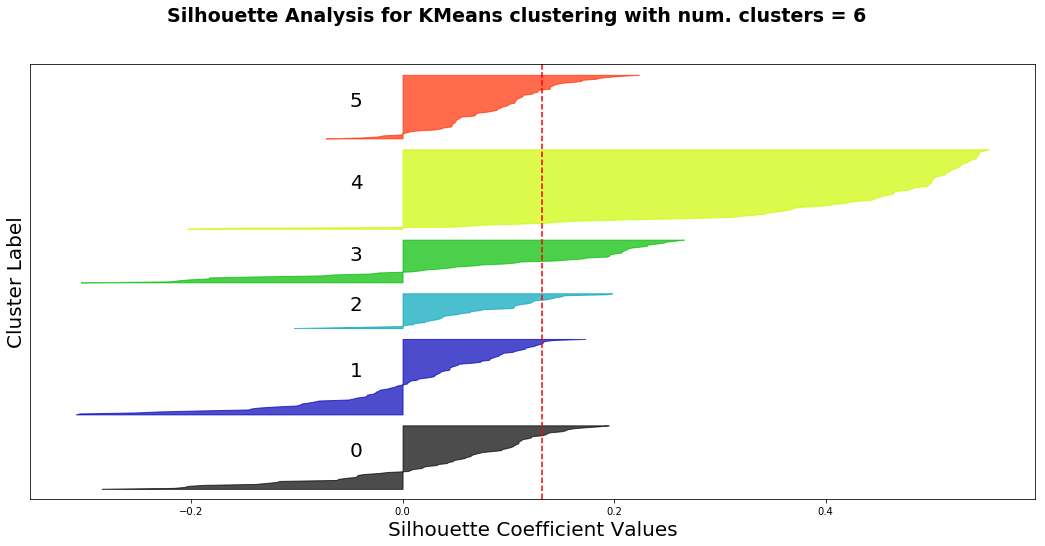

In [58]:
rangeK = [2, 3, 4, 5, 6] # values of K-clusters to test
seed = 3 # random seed for reproducibility

plotSilhouettes(weekday_X_train, rangeK, seed)


In [ ]:
# using library for silhouettes (http://www.scikit-yb.org/en/latest/api/cluster/silhouette.html)

# Instantiate the clustering model and visualizer
model = KShape(n_clusters=5, verbose=True, random_state=seed)

visualizer = SilhouetteVisualizer(model)

visualizer.fit(weekday_X_train) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

### Evaluate resulting clusters with elbow method

0.187 --> 0.168 --> 0.165 --> 0.166 --> 
0.175 --> 0.146 --> 0.140 --> 0.135 --> 0.132 --> 0.131 --> 0.139 --> 
0.180 --> 0.153 --> 0.141 --> 0.138 --> 0.134 --> 0.131 --> 0.129 --> 0.127 --> 0.126 --> 0.125 --> 0.124 --> 0.123 --> 0.122 --> 0.121 --> 0.121 --> 0.121 --> 0.121 --> 0.120 --> 0.120 --> 0.120 --> 0.120 --> 
0.146 --> 0.125 --> 0.119 --> 0.113 --> 0.108 --> 0.102 --> 0.108 --> 
0.155 --> 0.124 --> 0.111 --> 0.102 --> 0.093 --> 0.090 --> 0.096 --> 
0.163 --> 0.123 --> 0.112 --> 0.106 --> 0.104 --> 0.102 --> 0.101 --> 0.100 --> 0.099 --> 0.099 --> 0.100 --> 
0.143 --> 0.117 --> 0.102 --> 0.096 --> 0.093 --> 0.092 --> 0.091 --> 0.091 --> 0.090 --> 0.090 --> 0.090 --> 
0.157 --> 0.110 --> 0.096 --> 0.089 --> 0.084 --> 0.080 --> 0.078 --> 0.078 --> 


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



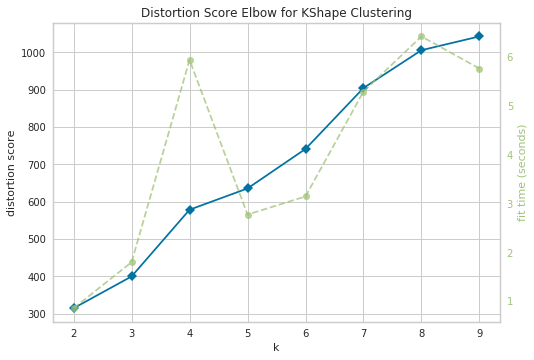

In [80]:
# using library (http://www.scikit-yb.org/en/latest/api/cluster/elbow.html)

# Instantiate the clustering model and visualizer
model = KShape(random_state=seed)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(weekday_X_train)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data


### Ratio of ground truth labels based on clustering